In [18]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


    Note: run in megabouts_dlc

In [19]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import tables
import flammkuchen as fl

#custom functions
from datetime import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from tqdm import tqdm

In [20]:
from segmentation_helper import nanzscore, reduce_to_pi, compute_tailsum, moving_average
from segmentation_helper import get_motor_pos, create_buffer_lists

# Set up paths

In [21]:
master_path = Path(Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Koetter-et-al_data\Testdata') / 'Raw_Data')
out_path = Path(master_path/'Processed_Data')
fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths

[WindowsPath('//portulab.synology.me/data/Kata/Figures_Paper/Koetter-et-al_data/Testdata/Raw_Data/240423_f0')]

In [22]:
fish= 0
fish_path = fish_paths[fish]
fish_id =  fish_paths[fish].name#[:-13]
exp_name = 'testfish'
exp_name, fish_id

('testfish', '240423_f0')

In [23]:
print ("{} videos found".format(len(fish_paths)))

1 videos found


In [24]:
## define time window for bout cropping
bout_duration = 50
pre_bout = 5

## Loop

In [43]:

for ind, fish_path in enumerate(tqdm(fish_paths)):
    fish_id =  fish_path.name
    print ('Working on fish {}'.format(fish_id))

    dlc_path_ = Path(out_path/ '{}_DLC_mod.csv'.format(fish_id)) 
    df_dlc = pd.read_csv(dlc_path_, header=[0,1])
    motor_x, motor_y, motor_z = get_motor_pos(df_dlc)
    dlc_filter_ = df_dlc.DLC_filter.pos.values
    edge_filter_ = df_dlc.edge_filter.ok.values

    data = fl.load(Path(out_path/ '{}_megabouts_res.h5'.format(fish_id)))
    print('working with {} detected bouts'.format(len(data['segments_on'])))

    eye_angles = fl.load(fish_path/'eye_angles.h5')['eye_angles']
    left_eye_angle = eye_angles[:,0]
    right_eye_angle = eye_angles[:,1]
    eye_rot = fl.load(fish_path/'eye_rot.h5')['eye_rot']
    eye_vergence = fl.load(fish_path/'eye_verg.h5')['eye_verg']

    #compute fin angles
    body_angle = fl.load(master_path/'body_angle.h5')
    fins = fl.load(master_path/'fin_angles.h5')
    left_fin_angle = fins[:,0]
    right_fin_angle = fins[:,1]
    
    cluster_n_vector,body_angles_delta,eye_angles_vector,fin_angles_vector,tail_vectors,tailsums ,body_angles,eye_vergence_vect,eye_rot_vect,bout_times ,motor_values ,mb_outlier,mb_proba ,dlc_filter,edge_filter = create_buffer_lists()
    lats_ =[]
    
    for i, on_ in enumerate(data['segments_on']):
            if on_+bout_duration<data['body_angle_deg'].shape[0]:
                on_ = on_ - pre_bout
                body_angle_delta = np.array(data['body_angle_deg'][on_+bout_duration]-data['body_angle_deg'][on_])*180/np.pi
                body_angles_delta.append(body_angle_delta)
                body_angles.append(data['body_angle_deg'][on_: on_ + bout_duration] - data['body_angle_deg'][on_])
                
                left_eye = left_eye_angle[on_ :on_+bout_duration]  -left_eye_angle[on_] 
                right_eye = right_eye_angle[on_ :on_+bout_duration] - right_eye_angle[on_]
                eye_angles_vector.append([left_eye, right_eye])
                
                left_fin = left_fin_angle[on_ :on_+bout_duration] -left_fin_angle[on_] 
                right_fin = right_fin_angle[on_ :on_+bout_duration]- right_fin_angle[on_]
                fin_angles_vector.append([left_fin, right_fin])
                eye_vergence_vect.append(eye_vergence[on_: on_ + bout_duration])
                eye_rot_vect.append(eye_rot[on_: on_ + bout_duration])
        
                cluster_n_vector.append(data['cluster_n_vector'][on_+pre_bout])
                tail_vectors.append(data['clean_data_tail'][:,:10][on_: on_ + bout_duration])
                tailsums.append(compute_tailsum(data['clean_data_tail'][:,:10][on_: on_ + bout_duration]))
    
                motor_values.append([motor_x[on_ :on_+bout_duration], motor_y[on_ :on_+bout_duration], motor_z[on_ :on_+bout_duration]])
    
                mb_proba.append(data['proba'][i])
                dlc_filter.append(dlc_filter_[on_+pre_bout])
                edge_filter.append(edge_filter_[on_+pre_bout])
                lats_.append(data['laterality'][i])
                bout_times.append([data['segments_on'][i], data['segments_off'][i]])

    
    data_to_save = dict({
        'tailsums': np.asarray(tailsums),
        'tail_vectors' : np.asarray(tail_vectors),
        'body_angles_delta': np.asarray(body_angles_delta),
        'body_angles' : np.asarray(body_angles),
    
        'eye_angles' : np.asarray(eye_angles_vector),
        'fin_angles' : np.asarray(fin_angles_vector),
        'eye_rotation': np.asarray(eye_rot_vect),
        'eye_vergence': np.asarray(eye_vergence_vect),
    
        'cluster': np.asarray(cluster_n_vector),
    
        'motor' : np.asarray(motor_values),
        'mb_proba' : np.asarray(mb_proba),
        'dlc_filter' : np.asarray(dlc_filter),
        'edge_filter' : np.asarray(edge_filter),
        'bout_times' : np.asarray(bout_times),
        'laterality' : np.asarray(lats_),
    
    })
    
    fl.save(out_path/'{}_bout_data.h5'.format(fish_id), data_to_save)





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Working on fish 240423_f0
working with 506 detected bouts


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


### check extracted data

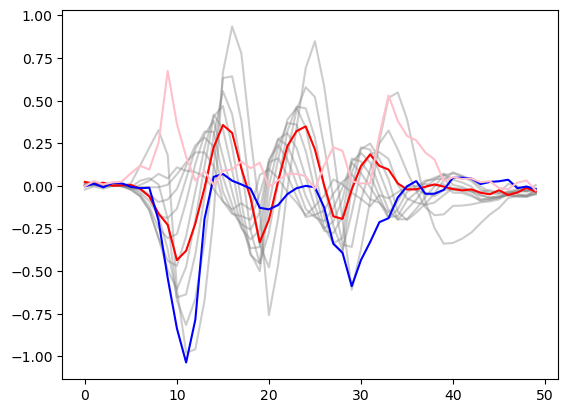

In [48]:
# Generate a random integer from 0 to num_elements - 1
bout = np.random.randint(0, np.asarray(tailsums).shape[0])
plt.figure()
plt.plot(np.asarray(tail_vectors)[bout, :, :10], c='gray', alpha=0.4)
plt.plot(np.asarray(tailsums)[bout], c='r')
plt.plot(np.asarray(fin_angles_vector)[bout, 0,:], c='blue')
plt.plot(np.asarray(fin_angles_vector)[bout, 1,:], c='pink')